### Imports

In [20]:
import os
import random

# Libraries for reading and manipulating data
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [2]:
PROJECT_DIR = os.path.join(os.path.dirname('preprocessing.ipynb'), os.pardir)

# Dataset

## Overview

In [3]:
is_df = pd.read_excel(f'{PROJECT_DIR}/data/raw/industrial_safety_and_health_database_with_accidents_description.xlsx')
is_df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [4]:
# Info
is_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk             425 non-null    object        
 10  Description               425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 36.6+ KB


In [5]:
# null count
is_df.isnull().sum()

Unnamed: 0                  0
Data                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Genre                       0
Employee or Third Party     0
Critical Risk               0
Description                 0
dtype: int64

In [6]:
# Dropping the index column
is_df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# Duplicates
is_df.duplicated().sum()

7

In [8]:
# Dropping duplicates
is_df.drop_duplicates(inplace=True)

In [9]:
print('Value Counts')
print('*'*50)
for col in is_df.columns:
    if col not in ['Data', 'Description']:
        print(is_df[col].value_counts())
        print('-'*50)

Value Counts
**************************************************
Countries
Country_01    248
Country_02    129
Country_03     41
Name: count, dtype: int64
--------------------------------------------------
Local
Local_03    89
Local_05    59
Local_01    56
Local_04    55
Local_06    46
Local_10    41
Local_08    27
Local_02    23
Local_07    14
Local_12     4
Local_09     2
Local_11     2
Name: count, dtype: int64
--------------------------------------------------
Industry Sector
Mining    237
Metals    134
Others     47
Name: count, dtype: int64
--------------------------------------------------
Accident Level
I      309
II      40
III     31
IV      30
V        8
Name: count, dtype: int64
--------------------------------------------------
Potential Accident Level
IV     141
III    106
II      95
I       45
V       30
VI       1
Name: count, dtype: int64
--------------------------------------------------
Genre
Male      396
Female     22
Name: count, dtype: int64
----------------------

## Genre | Accident Level | Potential Accident Level

In [10]:
# Label encoding
is_df['Genre'] = is_df['Genre'].apply(lambda x: {'Male': 0, 'Female': 1}[x])
is_df['Accident Level'] = is_df['Accident Level'].apply(lambda x: {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5}[x])
is_df['Potential Accident Level'] = is_df['Potential Accident Level'].apply(lambda x: {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}[x])

is_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      418 non-null    datetime64[ns]
 1   Countries                 418 non-null    object        
 2   Local                     418 non-null    object        
 3   Industry Sector           418 non-null    object        
 4   Accident Level            418 non-null    int64         
 5   Potential Accident Level  418 non-null    int64         
 6   Genre                     418 non-null    int64         
 7   Employee or Third Party   418 non-null    object        
 8   Critical Risk             418 non-null    object        
 9   Description               418 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 35.9+ KB


## Data (DateTime)

In [11]:
# Splitting date, month and year
is_df['Year'] = is_df['Data'].apply(lambda x: x.year)
is_df['Month'] = is_df['Data'].apply(lambda x: x.month)
is_df['Day'] = is_df['Data'].apply(lambda x: x.day)
is_df['Timestamp'] = is_df['Data'].apply(lambda x: x.timestamp())

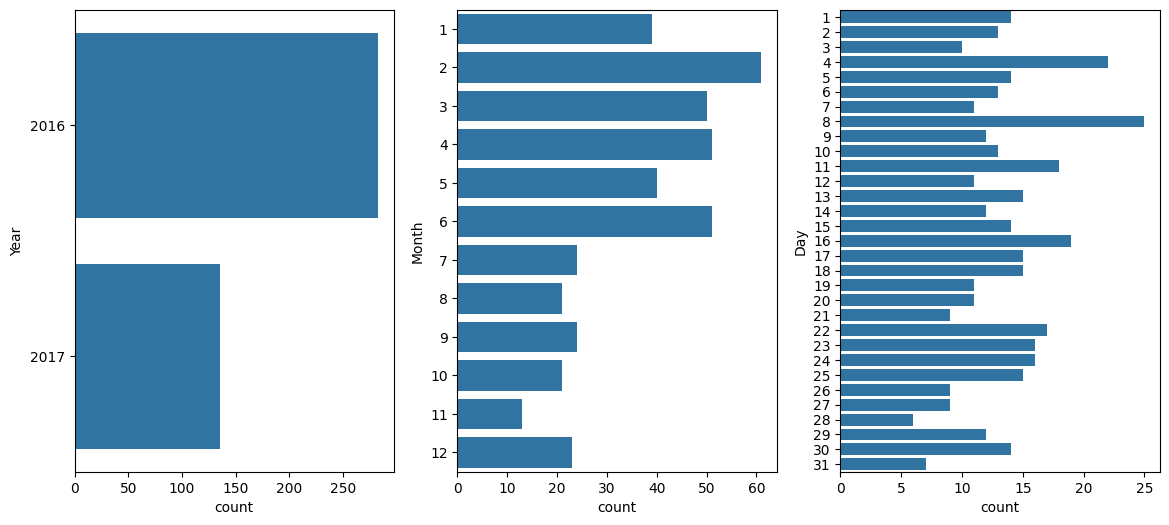

In [12]:
# Distribution
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
for i, col in enumerate(['Year', 'Month', 'Day']):
    sns.countplot(is_df[col].astype('category'), stat='count', ax=ax[i])

<Axes: xlabel='Month', ylabel='count'>

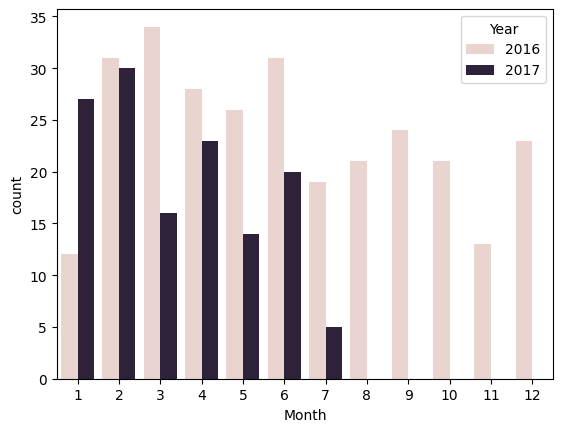

In [13]:
# Countplot
sns.countplot(is_df, x='Month', hue='Year', stat='count')

<Axes: xlabel='Accident Level', ylabel='count'>

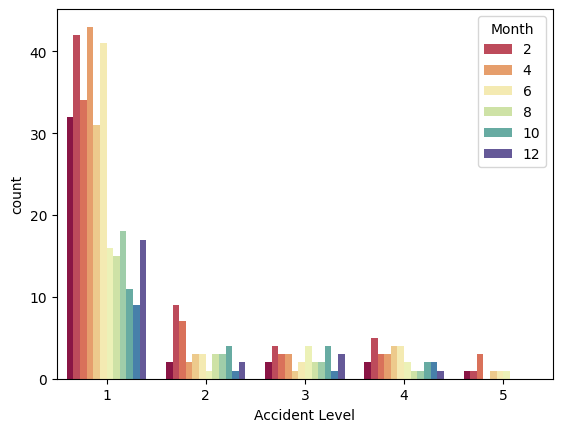

In [14]:
# Countplot
sns.countplot(is_df, x='Accident Level', hue='Month', stat='count', palette='Spectral')

<Axes: >

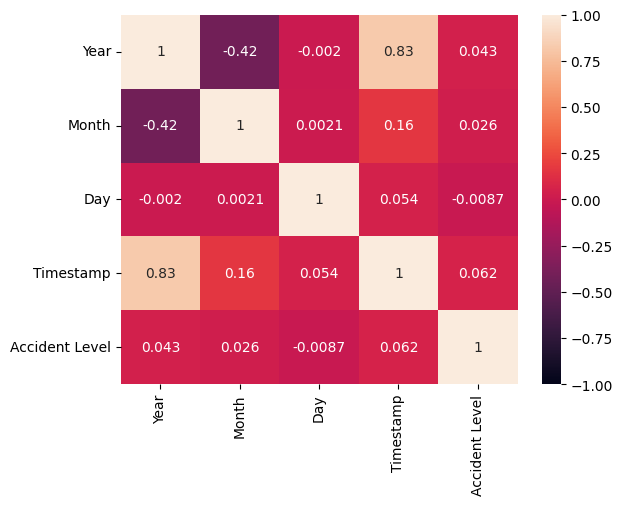

In [15]:
# Heatmap
sns.heatmap(is_df[['Year', 'Month', 'Day', 'Timestamp', 'Accident Level']].corr(), vmin=-1, vmax=1, annot=True)

In [16]:
# Dropping datetime info
is_df.drop(['Data', 'Year', 'Month', 'Day', 'Timestamp'], axis=1, inplace=True)

## Countries | Local | Industry Sector | Employee or Third Party

In [17]:
# One-hot encoding
for col in ['Countries', 'Local', 'Industry Sector', 'Employee or Third Party']:
    is_df = pd.concat([is_df, pd.get_dummies(is_df[col], prefix=col).astype('int64')], axis=1)
    is_df.drop(col, axis=1, inplace=True)

is_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 424
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Accident Level                                418 non-null    int64 
 1   Potential Accident Level                      418 non-null    int64 
 2   Genre                                         418 non-null    int64 
 3   Critical Risk                                 418 non-null    object
 4   Description                                   418 non-null    object
 5   Countries_Country_01                          418 non-null    int64 
 6   Countries_Country_02                          418 non-null    int64 
 7   Countries_Country_03                          418 non-null    int64 
 8   Local_Local_01                                418 non-null    int64 
 9   Local_Local_02                                418 non-null    int64 
 10  Local_L

## Critical Risk

## Description

In [25]:
# Set a random seed
rseed = 42
random.seed(rseed)
 
# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(rseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(rseed)

In [40]:
# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def generate_bert_embedding(sentences: list):
    # Tokenize and encode given list of sentences
    encoding = bert_tokenizer.batch_encode_plus(
        sentences,
        padding=True,
        truncation=True,
        return_tensors='pt',
        add_special_tokens=True
    )
    
    input_ids = encoding['input_ids']               # Token IDs
    attention_mask = encoding['attention_mask']     # Attntion mask
 
    # Generate embeddings
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        sentence_embeddings = outputs.last_hidden_state.mean(dim=1)
    
    return sentence_embeddings

In [41]:
# Generating embeddings for each Description text
description_embs = generate_bert_embedding(list(is_df['Description']))
description_embs.shape

torch.Size([418, 768])

In [ ]:
pd.DataFrame(description_embs).head()